## **Secure tool calling with Arcade.dev**

### **I. Introduction**

This tutorial will help you close one of the biggest gaps between demo and production agents: **Secure tool-calling**

When your agents work well in your computer, they are excellent personal assistants, but scaling that up to many users is not easy, as the security assumptions from a local deployment do not apply to agents at scale. Personal Access Tokens simply won't cut it for multiple users. Even if you encapsulate all of the functionality in a remote MCP server, tool-level auth will require you to implement the auth flow for all the providers that your agent relies on.

Arcade solves this by providing a unified platform for agentic tool execution. It will handle the auth flow for you offering a secure multi-user solutions for your agents.

In this tutorial you'll learn how to use Arcade and LangGraph to:
- Build agents
- Give tools that can interact with: Gmail, Slack, Notion
- Implement safety guardrails when calling specific tools (Human-in-the-Loop)

### **II. Setup enviroment**

#### **1. System flow**

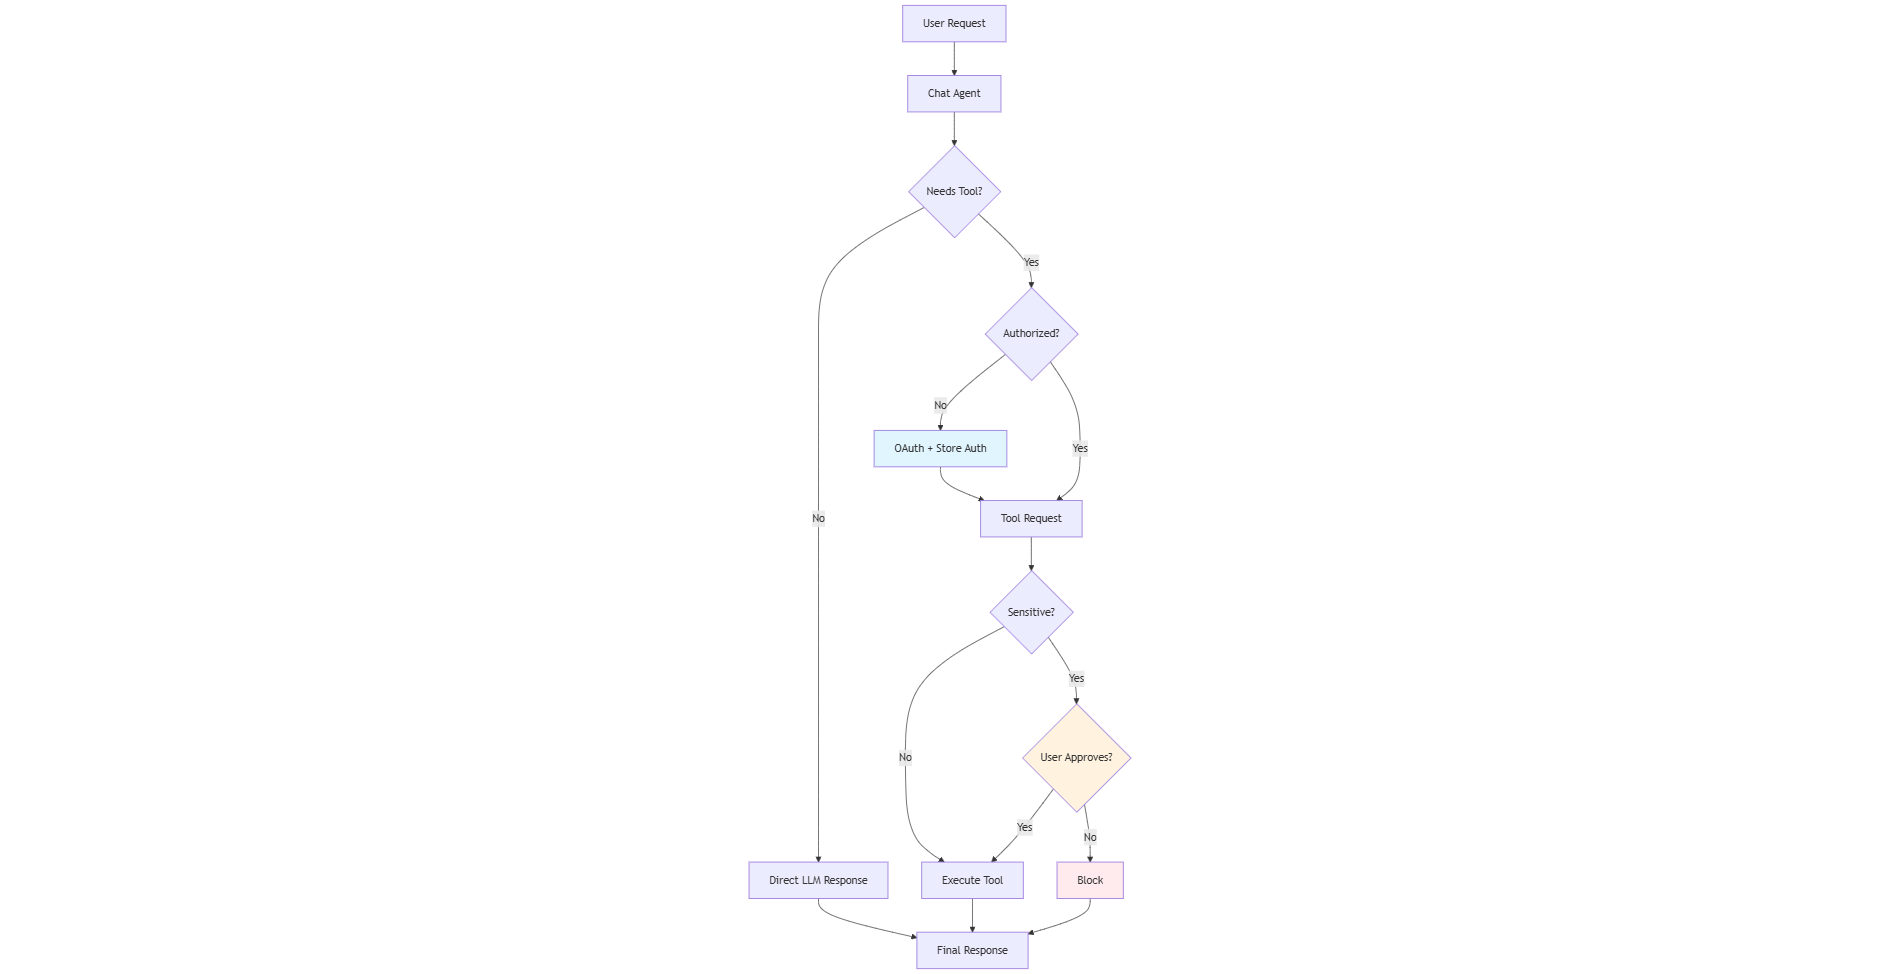

#### **2. Development Enviroment Setup**

In [38]:
!uv add langgraph langchain-arcade langchain-google-genai

Resolved 135 packages in 41ms
Audited 132 packages in 990ms


#### **3. API Key and User Identity Configuration**

GOOGLE_API_KEY + ARCADE_API_KEY + USER_ID (email address)

In [39]:
import os
import getpass
from dotenv import load_dotenv


def _set_env(key_name: str):

    load_dotenv()
    
    if key_name not in os.environ:
        if os.getenv(key_name) is not None:
            os.environ[key_name] = os.getenv(key_name)
        else:
            os.environ[key_name] = getpass.getpass(f"{key_name}:")


_set_env("GOOGLE_API_KEY")
_set_env("ARCADE_API_KEY")
_set_env("ARCADE_USER_ID")

### **III. Simple Conversational Agent**

We begin our journey by implementing a basic conversational agent that demonstrates core LangGraph functionality without external tool dependencies. This foundational agent provides conversational capabilities with short-term memory, allowing it to maintain context throughout a conversation while establishing the architectural patterns we'll extend throughout this tutorial.

#### **1. Core Agent Implementation**

The following implementation creates a React-style agent using LangGraph and Arcade. We configure it with conversation memory through a MemorySaver checkpointer, enabling the agent to remember previous interactions within the same conversation thread. The agent receives a clear prompt defining its helpful and concise personality, along with instructions for handling unclear requests.

In [40]:
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import HumanMessage 
from langchain_google_genai import ChatGoogleGenerativeAI
import uuid
import os

checkpointer = MemorySaver()

llm = ChatGoogleGenerativeAI(
    api_key = os.environ["GOOGLE_API_KEY"],
    model = "gemini-2.5-flash"
)

prompt = f"""
You are a helpful assistant that can help with everyday tasks.
If the user's request is confusing you must ask them to clarify
their intent, and fulfill the instruction to the best of your
ability. Be concise and friendly at all times.
""".strip()

agent_a = create_react_agent(
    model = llm,
    prompt = prompt,
    tools = [],
    checkpointer = checkpointer
)

#### **2. Agent Interaction Utility**

To facilitate consistent interaction with our agents throughout this tutorial, we implement a utility function that streams agent responses and displays them in a readable format. This function processes the graph's streaming output and presents the latest message from each interaction cycle, providing immediate feedback during agent conversations.

In [41]:
from langgraph.graph.state import CompiledStateGraph

def run_graph(graph: CompiledStateGraph, config, input):
    for event in graph.stream(input, config, stream_mode="values"):
        if "messages" in event:
            event["messages"][-1].pretty_print()

#### **3. Interactive Chat Interface**

THe following implementation provides a complete interactive chat interface for testing our basic agent. The system generates a unique conversation thread identifier for each session, enabling memory persistence accross multiple exchanges within the same conversation. Users can engage naturally with the agent and terminate the session by typing "exit".

In [42]:
# the configuration helps LangGraph keep track of conversations and interrups
# While it's not needed for this agent. The agent will remember different
# conversations based on the thread_id. This code generates a random id every
# time you run the cell, but you can hardcode the thread_id if you want to
# test the memory.

config = {
    "configurable": {
        "thread_id": uuid.uuid4()
    }
}

while True:
    user_input = input("User: ")
    if user_input.lower() == "exit":
        break

    user_message = {
        "messages": [HumanMessage(content=user_input)]
    }
    run_graph(agent_a, config, user_message)

#### **4. Testing Agent Limitations**

Most language models lack real-time data access and my provide outdated or inacurrate temporal information.

In [43]:
config = {
    "configurable": {
        "thread_id": uuid.uuid4()
    }
}
print(f'thread_id = {config["configurable"]["thread_id"]}')

prompt = "what's today's date?"
user_message = {"messages": [HumanMessage(content=prompt)]}
run_graph(agent_a, config, user_message)

thread_id = fe85d27f-8ef8-4e2f-9ca8-29e821677098
================================ Human Message =================================

what's today's date?
================================== Ai Message ==================================

Today is July 19, 2024!


#### **5. Demonstrating Authentication Requirements**

The following test illustrates the agent's complete inability to access private, authenticated data sources. When asked to summarize personal emails, the agent can't proceed without proper authentication mechanisms and authorized access to external services. This limitation highlights the critical need for secure tool integration in production agent systems.

In [44]:
config = {
    "configurable": {
        "thread_id": uuid.uuid4()
    }
}

print(f"thread_id = {config['configurable']["thread_id"]}")

prompt = "summarize my latest 3 emails please"
user_message = {"messages": [HumanMessage(content=prompt)]}
run_graph(agent_a, config, user_message)

thread_id = ef8beed0-18d7-446d-8065-c0033da17571
================================ Human Message =================================

summarize my latest 3 emails please
================================== Ai Message ==================================

I'm sorry, but I don't have access to your personal emails, so I can't summarize them for you.

If you'd like, you can copy and paste the content of your emails here, and I'd be happy to summarize them! 😊


### **IV. Tool Integration with Secure Authentication**

Having established our basic agent architecture, we now address the core challenge of enabling secure access to external services. This section demonstrates how Arcade.dev solves the complex problem of tool-level authentication, providing a streamlined approach to OAuth integration that scales across multiple users and services.

#### **1. Arcade Client Initialization**

We begin by establishing connections to the Arcade platform through both the core client and the LangChain integration layer. The ToolManager serves as our primary interface for configuring and authorizing tools, while the Arcade client handles the underlying authentication infrastructure.

In [45]:
from langchain_arcade import ToolManager
from arcadepy import Arcade

arcade_client = Arcade(api_key=os.environ["ARCADE_API_KEY"])
manager = ToolManager(client=arcade_client)

#### **2. Gmail Tool Configuration**

Our first tool integration focuses on Gmail access, specifically the email listing capability that our basic agent could not provide. The Gmail_ListEmails tool enables our agent to retrieve and analyze email data, but requires proper user authorization before it can access private email accounts.

In [46]:
gmail_tool = manager.init_tools(tools=["Gmail_ListEmails"])[0]

#### **3. Authorization Utility Function**

To streamline the authorization process throughout this tutorial, we implement a reusable function that handles OAuth flow initation and completion. For reading our email, however, we need to give our app permissions to read it in a secure way. Arcade lets us do this easily by handling the OAuth2 for us. This function checks the current authorization status for a specific tool and user combination, initiating the OAuth process when necessary and waiting for user completion of the authorization flow.

In [47]:
def authorize_tool(tool_name, user_id, manager):

    auth_response = manager.authorize(
        tool_name = tool_name,
        user_id = user_id
    )

    if auth_response.status != "completed":
        print(f"The app wants to use the {tool_name} tool.")
        print(f"Please click this url to authorize it {auth_response.url}")

        manager.wait_for_auth(auth_response.id)

#### **4. Gmail Authorization Process**

The following cell initiates the authorization process for Gmail access. If the user has not previously granted permissions, Arcade will provide an OAuth URL for completing the authorization. Once authorized, the permission persists for future sessions, eliminating the need for repeated authorization flows.

In [48]:
authorize_tool(gmail_tool.name, os.environ["ARCADE_USER_ID"], manager)

#### **5. Enhanced Agent with Gmail Capabilities**

With Gmail authorization complete, we can now create an enhanced agent that incorporates email access capabilities. This agent retains all the conversational abilities of our basic implementation while adding the power to interact with authenticated email services. Notice the updated prompt that explicity mentions Gamil capabilities and the inclusion of the user_id in the configuration for tool execution.

In [49]:
agent_prompt = f"""
You are a helpful assistant that can help with everyday tasks.
If the user's request is confusing you must ask them to clarify
their intent, and fulfill the instruction to the best of your
ability. Be concise and friendly at all times.
Use the Gmail tools that you have to address requests about emails.
""".strip()

agent_b = create_react_agent(
    model = llm,
    prompt = agent_prompt,
    tools = [gmail_tool],
    checkpointer = checkpointer
)

config = {
    "configurable": {
        "thread_id": uuid.uuid4(),
        "user_id": os.environ["ARCADE_USER_ID"]
    }
}
print(f'thread_id = {config["configurable"]["thread_id"]}')

prompt = "summarize my latest 3 emails please"
user_message = {"messages": [HumanMessage(content=prompt)]}
run_graph(agent_b, config, user_message)

thread_id = 038986f7-21dc-4e6e-9bc5-d82740614ab4
================================ Human Message =================================

summarize my latest 3 emails please
================================== Ai Message ==================================
Tool Calls:
  Gmail_ListEmails (a2183f97-599a-4ad7-9f57-9560d66935b3)
 Call ID: a2183f97-599a-4ad7-9f57-9560d66935b3
  Args:
    n_emails: 3
================================= Tool Message =================================
Name: Gmail_ListEmails

{"emails": [{"body": "Hello! How is it going so far? If you’re completely new to programming, even simple puzzles will be challenging. I suggest learning the basics of programming first, like String manipulation, arrays, conditionals and loops. Here's a couple of hints to help you get started 🤗 All the puzzles here work the same. You’re given a problem, and the skeleton of a program to solve it. The skeleton reads the inputs from the server and gives back a default (but incorrect) output. Just modify 

### **V. Multi-Service Tool Integration**

Building upon our successful Gmail integration, we now expand our agent's capabilities to include multiple external services. This section demonstrates how to efficiently manage authentication across multiple providers while maintaining security and user experience standards.

#### **1. Batch Authorization Utility**

Managing multiple tool authorizations individually becomes cumbersome as our agent's capabilities expand. This requires initializing multiple tools for the agent, and authenticating the scope of each tool. The following function streamlines this process by grouping authorization scopes by provider, minimizing the number of OAuth flows users must complete while ensuring comprehensive tool access.

In [50]:
def authorize_tools(tools, user_id, client):

    provider_to_scopes = {}
    for tool in tools:
        provider = tool.requirements.authorization.provider_id
        if provider not in provider_to_scopes:
            provider_to_scopes[provider] = set()

        if tool.requirements.authorization.oauth2.scopes:
            provider_to_scopes[provider] |= set(tool.requirements.authorization.oauth2.scopes)

    for provider, scopes in provider_to_scopes.items():
        auth_response = client.auth.start(
            user_id = user_id,
            scopes = list(scopes),
            provider = provider
        )

        if auth_response.status != "completed":
            print(f"🔗 Please click here to authorize: {auth_response.url}")
            print(f"⏳ Waiting for authorization completion...")

            # Wait for the authorization to complete with timeout
            client.auth.wait_for_completion(auth_response)

#### **2. Comprehensive Tool Suite Configuration**

We now expand our agent's capabilities by incorporating tools for email sending, Slack communication and Notion content management. This configuration provides our agent with the ability to not only read information from various services but also to create and send content, enabling more sophisticated workflow automation

In [51]:
manager.add_tool("Gmail.SendEmail")

manager.add_toolkit("Slack")
manager.add_toolkit("NotionToolkit")

#### **3. Multi-Service Authorization**

The following cell executes the authorization process for all configured tools simultaneously. This efficient approach minimizes user interaction while establishing the necessary permissions for Gmail, Slack and Notion access. The batch authorization system automatically groups scopes by provider to present the minimum number of authorization flows.

In [52]:
authorize_tools(
    tools = manager.definitions,
    user_id = os.environ["ARCADE_USER_ID"],
    client = arcade_client
)

#### **4. Multi-Service Agent Implementation**

With comprehensive tool authorization complete, we create our most capable agent yet. This implementation leverages the ToolManager's LangChain conversion functionality to provide seamless integration between Arcade's tool definitions and LangGraph's execution framework. The enhanced prompt guides the agent selecting appropriate tools for different types of requests.

In [53]:
system_prompt = f"""
You are a helpful assistant that can help with everyday tasks.
If the user's request is confusing you must ask them to clarify
their intent, and fulfill the instruction to the best of your
ability. Be concise and friendly at all times.
It's useful to let the agent know about the tools it has at its disposal.
Use the Gmail tools to address requests about reading or sending emails.
Use the Slack tools to address requests about interactions with users and channels in Slack.
Use the Notion tools to address requests about managing content in Notion Pages.
In general, when possible, use the most relevant tool for the job.
""".strip()

agent_c = create_react_agent(
    model = llm,
    prompt = system_prompt,
    tools = manager.to_langchain(),
    checkpointer = checkpointer
)

#### **5. Complex Multi-Service Task Execution**

This demonstration showcases our agent's ability to orchestrate complex workflows across multiple services. The request requires the agent to analyze email data, retrieve Slack communications, and explore Notion workspace structure, demonstrating sophisticated tool selection and execution coordination.

In [54]:
config = {
    "configurable": {
        "thread_id": uuid.uuid4(),
        "user_id": os.getenv("ARCADE_USER_ID") # When using Arcade tools, we must provide the user_id on the LangGraph config, so Arcade can execute the tool invoked by the agent.
    }
}
print(f'thread_id = {config["configurable"]["thread_id"]}')

# we're using the same prompt we use before, but we're swapping the agent
prompt = "summarize my latest 3 emails, then show me the latest 3 messages in the #general Slack channel, and tell me about the structure of my Notion Workspace"
user_message = {"messages": [HumanMessage(content=prompt)]}
run_graph(agent_c, config, user_message)

thread_id = f83eebb6-c4e9-4657-aea1-37ced69f0e10
================================ Human Message =================================

summarize my latest 3 emails, then show me the latest 3 messages in the #general Slack channel, and tell me about the structure of my Notion Workspace
================================== Ai Message ==================================
Tool Calls:
  Gmail_ListEmails (14f2c004-d540-4a80-a445-4ec039e2eabe)
 Call ID: 14f2c004-d540-4a80-a445-4ec039e2eabe
  Args:
    n_emails: 3
  Slack_GetMessages (38ece1cb-7099-4631-99b3-e39d804116be)
 Call ID: 38ece1cb-7099-4631-99b3-e39d804116be
  Args:
    channel_name: general
    limit: 3
  NotionToolkit_GetWorkspaceStructure (f61b364d-8b13-4d61-a12d-4957c4dc0fd3)
 Call ID: f61b364d-8b13-4d61-a12d-4957c4dc0fd3
  Args:
================================= Tool Message =================================
Name: NotionToolkit_GetWorkspaceStructure

{"workspace": []}
================================== Ai Message =======================

### **VI. Human-in-the-Loop Safety Implementation**

While our multi-service agent demonstrates impressive capabilities, production systems require robust safety mechanisms to prevent unintended actions. This section implements human-in-the-loop controls for sensitive operations, ensuring that potentially harmful or irreversible actions require explicit user approval before execution

#### **1. Identifying Sensitive Operations**

Before implementing safety controls, we must identify which tools require human oversight. The following examination of available tools helps us categorize operations based on their potential impact and irreversibility.

In [55]:
for tool_name, _ in manager:
    print(tool_name)

Gmail_ListEmails
Gmail_SendEmail
Slack_GetChannelMetadataByName
Slack_GetConversationMetadata
Slack_GetConversationMetadataById
Slack_GetDirectMessageConversationMetadataByUsername
Slack_GetMembersInChannelByName
Slack_GetMembersInConversationById
Slack_GetMessages
Slack_GetMessagesInChannelByName
Slack_GetMessagesInConversationById
Slack_GetMessagesInDirectMessageConversationByUsername
Slack_GetMessagesInMultiPersonDmConversationByUsernames
Slack_GetMultiPersonDmConversationMetadataByUsernames
Slack_GetUserInfoById
Slack_GetUsersInConversation
Slack_GetUsersInfo
Slack_ListConversations
Slack_ListConversationsMetadata
Slack_ListDirectMessageConversationsMetadata
Slack_ListGroupDirectMessageConversationsMetadata
Slack_ListPrivateChannelsMetadata
Slack_ListPublicChannelsMetadata
Slack_ListUsers
Slack_SendDmToUser
Slack_SendMessage
Slack_SendMessageToChannel
Slack_WhoAmI
NotionToolkit_AppendContentToEndOfPage
NotionToolkit_CreatePage
NotionToolkit_GetObjectMetadata
NotionToolkit_GetPageCo

#### **2. Sensitive Tool Classification**

Based on potential impact analysis, we identify tools that could cause unintended consequences if executed with incorrect parameters. These tools typically involve creating, sending, or modifying data rather than simply retrieving information. The classification focuses on operations that have external effects or could compromise user privacy or system integrity.

In [56]:
tools_to_protect = [
    "Gmail_SendEmail",
    "Slack_SendDmToUser",
    "Slack_SendMessage",
    "Slack_SendMessageToChannel",
    "NotionToolkit_AppendContentToEndOfPage",
    "NotionToolkit_CreatePage",
]

#### **3. Human-in-the-Loop Tool Wrapper**

The following implementation creates a wrapper function that transforms regular tools into human-supervised versions. This wrapper intercepts tool execution requests, presents the planned action to the user for approval, and only proceeds with execution upon receiving explicit consent. The implementation leverages LangGraph's interrupt mechanism to pause execution pending user input.

In [57]:
from typing import Callable, Any
from langchain_core.tools import tool, BaseTool
from langgraph.types import interrupt, Command
from langchain_core.runnables import RunnableConfig
import pprint

def add_human_in_the_loop(
    target_tool: Callable | BaseTool
) -> BaseTool:
    """Wrap a tool to support human-in-the-loop review."""
    if not isinstance(target_tool, BaseTool):
        target_tool = tool(target_tool)

    @tool(
        target_tool.name,
        description = target_tool.description,
        args_schema = target_tool.args_schema
    )
    def call_tool_with_interrupt(config: RunnableConfig, **tool_input):
        arguments = pprint.pformat(tool_input, indent=4)
        response = interrupt(
            f"Do you allow the call to {target_tool.name} with arguments:\n"
            f"{arguments}?"
        )

        if response == "yes":
            tool_response = target_tool.invoke(tool_input, config)
        elif response == "no":
            tool_response = "The user didn't allow the tool to run"
        else:
            raise ValueError(
                f"Unsupported interrupt response type: {response}"
            )

        return tool_response
    
    return call_tool_with_interrupt

#### **4. Selective Tool Protection Application**

This implementation applies human-in-the-loop protection selectively, wrapping only the tools identified as sensitive while leaving read-only operations unchanged. This approach maintains agent efficiency for safe operations while ensuring appropriate oversight for potentially risky actions.

In [58]:
protected_tools = [
    add_human_in_the_loop(t)
    if t.name in tools_to_protect else t
    for t in manager.to_langchain()
]

#### **5. Interrupt Handling Utilities**

LangGraph interrupts require specialized handling to resume execution after user input. The following utilities provide a user-friendly interface for approval decisions and automate the process of resuming agent execution with the user's response. The yes/no loop ensures clear decision-making while the interrupt handler manages the technical aspects of execution resumption.

In [59]:
def yes_no_loop(prompt: str) -> str: 
    # "Force the user to say yes or no"
    print(prompt)
    user_input = input("Your_response [y/n]: ")
    while user_input.lower() not in ["y", "n"]:
        user_input = input("Your response (must be 'y' or 'n'): ")
    return "yes" if user_input.lower() == "y" else "no"

def handle_interrupts(graph: CompiledStateGraph, config):
    for interr in graph.get_state(config).interrupts:
        approved = yes_no_loop(interr.value)
        run_graph(graph, config, Command(resume=approved))

#### **6. Protected Agent Implementation**

Our final agent implementation incorporates comprehensive safety controls while maintain all the multi-service capabilities developed throughout this tutorial. This agent represents a production-ready system that balanced functionality with security, ensuring that users maintain control over sensitive operations while benefiting from automated assistance for routine tasks.

In [60]:
system_prompt = f"""
You are a helpful assistant that can help with everyday tasks.
If the user's request is confusing you must ask them to clarify
their intent, and fulfill the instruction to the best of your
ability. Be concise and friendly at all times.
It's useful to let the agent know about the tools it has at its disposal.
Use the Gmail tools to address requests about reading or sending emails.
Use the Slack tools to address requests about interactions with users and channels in Slack.
Use the Notion tools to address requests about managing content in Notion Pages.
In general, when possible, use the most relevant tool for the job.
""".strip()

agent_final = create_react_agent(
    model = llm,
    prompt = system_prompt,
    tools = protected_tools,
    checkpointer = checkpointer
)

#### **7. Safety Mechanism Demonstration**

The following test demonstrates our safety system in action by attempting to send a potentially sensitive email. This scenario illustrates how the human-in-the-loop mechanism intercepts the action, presents the details for user review, and awaits explicit approval before procedding with execution.

In [61]:
config = {
    "configurable": {
        "thread_id": uuid.uuid4(),
        "user_id": os.environ["ARCADE_USER_ID"] # When using Arcade tools, we must provide the user_id on the LangGraph config, so Arcade can execute the tool invoked by the agent.
    }
}
print(f'thread_id = {config["configurable"]["thread_id"]}')

# we're using the same prompt we use before, but we're swapping the agent
prompt = 'send an email with subject "confidential data" and body "this is top secret information" to random-dude@example.com'
user_message = {"messages": [HumanMessage(content=prompt)]}
run_graph(agent_final, config, user_message)

thread_id = a9b1e655-278c-42fc-946b-c66475dd6397
================================ Human Message =================================

send an email with subject "confidential data" and body "this is top secret information" to random-dude@example.com
================================== Ai Message ==================================
Tool Calls:
  Gmail_SendEmail (7fde82d2-ad2c-409f-81f1-22ddfed84d71)
 Call ID: 7fde82d2-ad2c-409f-81f1-22ddfed84d71
  Args:
    recipient: random-dude@example.com
    body: this is top secret information
    subject: confidential data


#### **8. Interrupt State Inspection**

When our safety system activates, the agent execution pauses and enters an interrupt state. The following examination reveals the pending approval request, demonstrating how the system captures the intended action details and awaits user decision before proceeding.

In [62]:
agent_final.get_state(config).interrupts

(Interrupt(value="Do you allow the call to Gmail_SendEmail with arguments:\n{   'body': 'this is top secret information',\n    'recipient': 'random-dude@example.com',\n    'subject': 'confidential data'}?", id='8d68626caa0f846d8dd5271689b2f6cb'),)

#### **9. User Decision Processing**

The following cell processes the pending interrupt, presenting the action details to the user and collecting their approval decision. This demonstration shows how users can review potentially sensitive actions and make informed decisions about whether to proceed with agent-proposed operations.

In [63]:
handle_interrupts(agent_final, config)

Do you allow the call to Gmail_SendEmail with arguments:
{   'body': 'this is top secret information',
    'recipient': 'random-dude@example.com',
    'subject': 'confidential data'}?
================================== Ai Message ==================================
Tool Calls:
  Gmail_SendEmail (7fde82d2-ad2c-409f-81f1-22ddfed84d71)
 Call ID: 7fde82d2-ad2c-409f-81f1-22ddfed84d71
  Args:
    recipient: random-dude@example.com
    body: this is top secret information
    subject: confidential data
================================= Tool Message =================================
Name: Gmail_SendEmail

{"body": "", "cc": "", "date": "", "from": "", "header_message_id": "", "history_id": "", "id": "199fa8c937927c90", "in_reply_to": "", "label_ids": ["SENT"], "references": "", "reply_to": "", "snippet": "", "subject": "", "thread_id": "199fa8c937927c90", "to": "", "url": "https://mail.google.com/mail/u/0/#sent/199fa8c937927c90"}
================================== Ai Message ===================

#### **10. Complete Interactive System**

The final implementation provides a complete interactive system that combines all the capabilities developed throughout this tutorial. Users can engage in natural conversations with an agent that has access to multiple external services while maintaining safety through human-in-the-loop controls for sensitive operations. The system automatically handles authorization, tool execution and safety approvals in a seamless user experience.

In [67]:
config = {
    "configurable": {
        "thread_id": uuid.uuid4(),
        "user_id": os.environ["ARCADE_USER_ID"] # When using Arcade tools, we must provide the user_id on the LangGraph config, so Arcade can execute the tool invoked by the agent.
    }
}
while True:
    user_input = input("👤: ")
    # let's use "exit" as a safe way to break the infinite loop
    if user_input.lower() == "exit":
        break

    user_message = {"messages": [HumanMessage(content=user_input)]}

    run_graph(agent_final, config, user_message)

    handle_interrupts(agent_final, config)

================================ Human Message =================================

send to sfw839@gmail.com an email with body is "test" and title is "test agent"
================================== Ai Message ==================================
================================ Human Message =================================




d:\AI Agent Tutorials\.venv\Lib\site-packages\langchain_google_genai\chat_models.py:2007: UserWarning: HumanMessage with empty content was removed to prevent API error
  warnings.warn(


================================== Ai Message ==================================
================================ Human Message =================================

y


d:\AI Agent Tutorials\.venv\Lib\site-packages\langchain_google_genai\chat_models.py:2007: UserWarning: HumanMessage with empty content was removed to prevent API error
  warnings.warn(


================================== Ai Message ==================================
================================ Human Message =================================




d:\AI Agent Tutorials\.venv\Lib\site-packages\langchain_google_genai\chat_models.py:2007: UserWarning: HumanMessage with empty content was removed to prevent API error
  warnings.warn(


================================== Ai Message ==================================
Tool Calls:
  Gmail_SendEmail (bfc0df48-4e31-4fd2-aff0-de69b4ea02ea)
 Call ID: bfc0df48-4e31-4fd2-aff0-de69b4ea02ea
  Args:
    recipient: sfw839@gmail.com
    body: test
    subject: test agent
Do you allow the call to Gmail_SendEmail with arguments:
{'body': 'test', 'recipient': 'sfw839@gmail.com', 'subject': 'test agent'}?
================================== Ai Message ==================================
Tool Calls:
  Gmail_SendEmail (bfc0df48-4e31-4fd2-aff0-de69b4ea02ea)
 Call ID: bfc0df48-4e31-4fd2-aff0-de69b4ea02ea
  Args:
    recipient: sfw839@gmail.com
    body: test
    subject: test agent
================================= Tool Message =================================
Name: Gmail_SendEmail

{"body": "", "cc": "", "date": "", "from": "", "header_message_id": "", "history_id": "", "id": "199fa947a53f8920", "in_reply_to": "", "label_ids": ["SENT"], "references": "", "reply_to": "", "snippet": "", "sub

d:\AI Agent Tutorials\.venv\Lib\site-packages\langchain_google_genai\chat_models.py:2007: UserWarning: HumanMessage with empty content was removed to prevent API error
  warnings.warn(


================================== Ai Message ==================================

I have sent the email to sfw839@gmail.com with the subject "test agent" and body "test".
